In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
%matplotlib inline 
%precision 5

'%.5f'

In [2]:
##-------------------------------------------##
##   BASIC THINGS I NEED FOR EVERY MESH
##-------------------------------------------##

## Define shape function in terms of x
def N1(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x2e-x)

def N2(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x-x1e)

## Define gradients of shape functions 
def dN1dx(x,x1e,x2e):
    le = x2e-x1e
    return -1./le

def dN2dx(x,x1e,x2e):
    le = x2e-x1e
    return 1./le


In [3]:
# integration scheme
gauss_2 = np.array([[-1./np.sqrt(3.),1.],[1./np.sqrt(3.),1]])
gauss_3 = np.array([[-np.sqrt(3./5.),5./9.],[0,8./9.],[np.sqrt(3./5.),5./9.]])
gauss_4 = np.array([[-0.861136,0.347855],[-0.339981,0.652145],[0.339981,0.652145],[0.861136,0.347855]])
gauss_5 = np.array([[-0.90618,0.236927],[-0.538469,0.478629],[0,0.568889],[0.538469,0.478629],[0.90618,0.236927]])


In [17]:
##-------------------------------------------##
##   transient heat transfer
##-------------------------------------------##

L = 10.0
s0 = -0.05 # W/m2/s, note the source is s=s0*x
A0 = 0.5 # m^2 
k = 1.0 # W/C/m
qn = 0 # W/m^2

# Setting up loop over 4 meshes
n_ele = 16
n_node = n_ele+1 # in this case, nodes are always one more than elements 
node_X = np.arange(n_ele+1)*L/n_ele
elements = np.zeros((n_ele,2),dtype=int)
elements[:,0] = np.arange(n_ele) # first colum is just sequential from 0 to n_ele
elements[:,1] = np.arange(n_ele)+1 
T_sols = []  # array to store all solutions

# Initial condition, make all nodes temperature 0 
T_0 = np.zeros((n_node))
# fill in initial profile 
for i in range(n_node):
    T_0[i] = 30+0.5*node_X[i]**2
T_sols.append(T_0)

# loop over time steps 
delta_t = 0.1 # there is some considerations as to what is a good time step 
total_steps = 2000
for j in range(total_steps):
    ##-------------------------------------------------------------------------##
    ## SETTING UP STIFFNESS MATRIX, MASS MATRIX AND FORCE VECTORS
    ##-------------------------------------------------------------------------##
    # assemble global stiffness and body force 
    K = np.zeros((n_node,n_node))
    M = np.zeros((n_node,n_node))
    F_s = np.zeros(n_node)
    F_q = np.zeros(n_node)
    F_0 = np.zeros(n_node)
    # Loop over elements 
    for i in range(n_ele):
        # Beginning and end 'x' coordinates of this element 
        x1e = node_X[elements[i,0]]
        x2e = node_X[elements[i,1]]
        le = x2e-x1e 
        ##----------------------------------------##
        # READ TEMPERATURE FROM PREVIOUS TIME STEP
        ##----------------------------------------##
        T1e = T_0[elements[i,0]]
        T2e = T_0[elements[i,1]]
        #
        # stiffness matrix for this element (already derived)
        Ke = A0*k/le*np.array([[1.,-1],[-1.,1]])
        # Assemble into global stiffness 
        K[elements[i,0],elements[i,0]] += Ke[0,0]
        K[elements[i,0],elements[i,1]] += Ke[0,1]
        K[elements[i,1],elements[i,0]] += Ke[1,0]
        K[elements[i,1],elements[i,1]] += Ke[1,1]
        # Body force for this element, need to integrate b0 over the element
        Fes = np.zeros((2))
        for ip in range(len(gauss_2)):
            x_i = 0.5*(x1e+x2e) + 0.5*gauss_2[ip,0]*le 
            J = le/2. 
            Nvec = np.array([N1(x_i,x1e,x2e),N2(x_i,x1e,x2e)])
            s=s0*x_i
            Fes += J*gauss_2[ip,1]*Nvec*s # note source term is actually constant
        # Assemble into global force vector
        F_s[elements[i,0]] += Fes[0]
        F_s[elements[i,1]] += Fes[1]
        #
        ##--------------------------------##
        # MASS MATRIX
        ##--------------------------------##
        Me = np.zeros((2,2))
        for ip in range(len(gauss_2)):
            x_i = 0.5*(x1e+x2e) + 0.5*gauss_2[ip,0]*le 
            J = le/2. 
            Nvec = np.array([N1(x_i,x1e,x2e),N2(x_i,x1e,x2e)])
            Me += J*gauss_2[ip,1]*np.outer(Nvec,Nvec)
        # Assemble into global 
        M[elements[i,0],elements[i,0]] += Me[0,0]
        M[elements[i,0],elements[i,1]] += Me[0,1]
        M[elements[i,1],elements[i,0]] += Me[1,0]
        M[elements[i,1],elements[i,1]] += Me[1,1]
        #
        ##--------------------------------##
        # INITIAL 'FORCE' VECTOR
        ##--------------------------------##
        fe0 = np.zeros((2))
        for ip in range(len(gauss_2)):
            x_i = 0.5*(x1e+x2e) + 0.5*gauss_2[ip,0]*le 
            J = le/2. 
            Nvec = np.array([N1(x_i,x1e,x2e),N2(x_i,x1e,x2e)])
            T_i = N1(x_i,x1e,x2e)*T1e + N2(x_i,x1e,x2e)*T2e
            fe0 += J*gauss_2[ip,1]*Nvec*T_i
        # Assemble into global 
        F_0[elements[i,0]] += fe0[0]
        F_0[elements[i,1]] += fe0[1]
    
    ##---------------------------------------------##
    ## SOLVE FOR THE TEMPERATURE 
    ##---------------------------------------------##
    n_E = 1 # nodes 1 essential boundary conditions 
    n_F = n_node-1 # the rest of the nodes are free 
    # External fluxes, only last node has flux
    F_q = np.zeros((n_node))
    F_q[-1] = qn*A0 # only last node has flux 
    # known temperature
    d_E = np.array([30.]) # node 1 is fixed temperature T=0
    # partition of stiffness matrix
    K_E = K[0:n_E,0:n_E]
    K_F = K[n_E:,n_E:]
    K_EF = K[0:n_E,n_E:]
    # partition of mass matrix 
    M_E = M[0:n_E,0:n_E]
    M_F = M[n_E:,n_E:]
    M_EF = M[0:n_E,n_E:]
    # known boundary flux and source term and previous time step 'force'
    F_F = -F_q[n_E:] + F_s[n_E:] + (1./delta_t)*F_0[n_E:]
    # solving A\b
    d_F = np.linalg.solve((1.0/delta_t)*M_F+K_F,F_F- np.dot((1.0/delta_t)*M_EF.transpose()+K_EF.transpose(),d_E))
    # you can print if you want
    #print(d_F)
    # Assemble the vector with the full solution [d_E,d_F], becase right now I have two
    # separate vectors 
    node_T = np.zeros((n_node))
    node_T[0:n_E] = d_E
    node_T[n_E:] = d_F
    # store into the array of solutions 
    T_sols.append(node_T)
    ##---------------------------------------------##
    ## RESET T0 FOR THE TIME LOOP 
    ##---------------------------------------------##
    T_0 = node_T 

In [18]:
## ANIMATING
from matplotlib import animation, rc, patches
from IPython.display import HTML

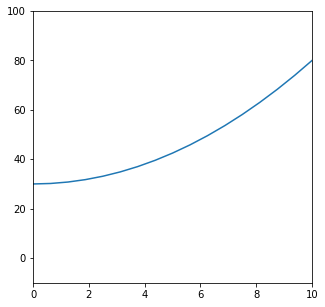

In [19]:
## Create figure and set up axes
##-------------------------------
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111, frameon=True)

## Set limits to the x and y axes
#ax.set_xlim(( -11, 11))
#ax.set_ylim((-11, 11))
ax.set_xlim(( 0, 10))
ax.set_ylim((-10, 100))


## Initialize plot
x_vec = np.linspace(0,10,n_node)
P, = ax.plot(x_vec, T_sols[0])

## animation function. This is called sequentially
##------------------------------------------------
dt = 10 # ms
def update(frame):
    P.set_data(x_vec,T_sols[frame])


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update,interval=dt,frames=2000)

In [20]:
HTML(anim.to_html5_video())

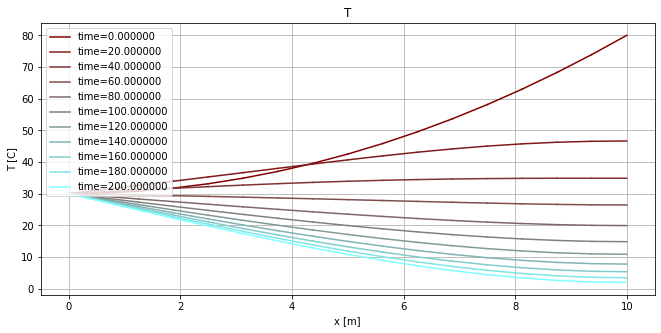

In [21]:
## plot a function over the domain by plotting in each element 

fig, (ax1) = plt.subplots(1, 1, figsize=(11,5))
frac = 200
for j in range(int(total_steps/frac)+1):
     
    node_T = T_sols[j*frac]
    
    # Plot the FE solution
    # Loop over elements 
    for i in range(n_ele):
        # Read the nodes that make up this element 'i'
        n1 = elements[i,0] 
        n2 = elements[i,1]
        # Beginning and end 'x' coordinates of this element 
        x1e = node_X[n1]
        x2e = node_X[n2]
        # Get the nodal values of the function 'T'
        T1e = node_T[n1]
        T2e = node_T[n2]
        # Eval the shape function evaluation for multiple x in this element
        x_vec = np.linspace(x1e,x2e,50)
        # use the shape functions to interpolate from the nodal T values to all the 'x'
        T_vec = N1(x_vec,x1e,x2e)*T1e + N2(x_vec,x1e,x2e)*T2e
        # gradient is going to be constant in this case
        dTdx = dN1dx(x_vec,x1e,x2e)*T1e + dN2dx(x_vec,x1e,x2e)*T2e
        dTdx_vec = dTdx*np.ones(50)
        # plot function T
        # some trick to get the legend 
        if i==0:
            ax1.plot(x_vec,T_vec,color=[0.5,j/total_steps*frac,j/total_steps*frac],label='time=%f'%(j*frac*delta_t))
        else:
            ax1.plot(x_vec,T_vec,color=[0.5,j/total_steps*frac,j/total_steps*frac])

    
# Plot the exact solution
#x_ls = np.linspace(0,10,100)
#ax1.plot(x_ls,T_exact(x_ls),'--',zorder=4,color='black',label='exact')
ax1.grid(True)
ax1.set_title('T')
ax1.set(xlabel='x [m]', ylabel='T [C]')
ax1.legend(loc=2)
